Dataset shape: (94455, 32)
Number of frames: 94455

Button usage frequency:
down     0.267270
right    0.198708
left     0.186279
Y        0.079562
up       0.039320
B        0.039320
R        0.028119
L        0.000138
A        0.000116
X        0.000116
dtype: float64

Most common button combinations:
              47884
down+left      7531
down           7525
down+right     7524
left           5680
right          4391
left+Y         3774
right+Y        3741
up+right+B     3108
down+R         2656
Name: count, dtype: int64

Character distribution:
p1_character_id
4     20313
7     11853
6     10125
1      9435
5      8068
3      7754
2      6942
10     6389
8      5872
11     4781
9      1670
0      1253
Name: count, dtype: int64

Button usage by distance:
                         up      down      left     right         A         B  \
distance_category                                                               
Very Close         0.005068  0.179242  0.125751  0.076764  0.000000  

C:\Users\jawad\AppData\Local\Temp\ipykernel_2596\1915550772.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_button_usage = data.groupby('distance_category')[button_cols].mean()


<Figure size 1200x800 with 0 Axes>

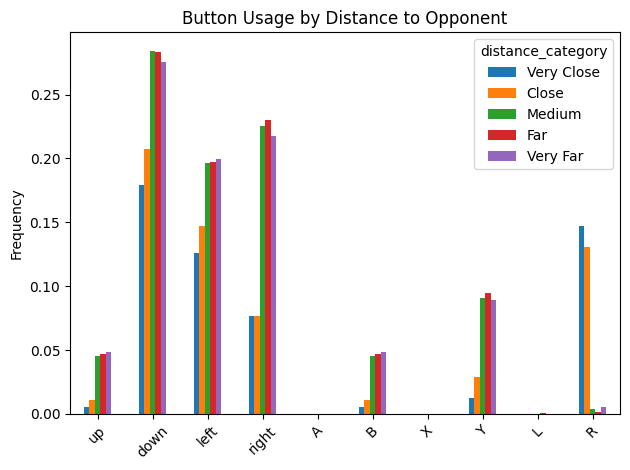

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the existing data
data = pd.read_csv('training_data.csv')

# Basic analysis
print(f"Dataset shape: {data.shape}")
print(f"Number of frames: {len(data)}")

# Check the distribution of button presses
button_cols = ['up', 'down', 'left', 'right', 'A', 'B', 'X', 'Y', 'L', 'R']
button_usage = data[button_cols].mean().sort_values(ascending=False)
print("\nButton usage frequency:")
print(button_usage)

# Check combinations of buttons (how often buttons are pressed together)
print("\nMost common button combinations:")
button_combinations = data[button_cols].apply(lambda row: '+'.join([col for col, val in row.items() if val == 1]), axis=1)
combo_counts = button_combinations.value_counts().head(10)
print(combo_counts)

# Check character distribution
print("\nCharacter distribution:")
print(data['p1_character_id'].value_counts())

# Check for potential relationship between distance and actions
data['distance'] = abs(data['p1_x'] - data['p2_x'])
distance_bins = [0, 30, 60, 100, 200, np.inf]
data['distance_category'] = pd.cut(data['distance'], bins=distance_bins, labels=['Very Close', 'Close', 'Medium', 'Far', 'Very Far'])

# Check which buttons are pressed at different distances
print("\nButton usage by distance:")
distance_button_usage = data.groupby('distance_category')[button_cols].mean()
print(distance_button_usage)

# Plot button usage by distance
plt.figure(figsize=(12, 8))
distance_button_usage.T.plot(kind='bar')
plt.title('Button Usage by Distance to Opponent')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('button_usage_by_distance.png')
plt.show()

In [7]:
import pandas as pd
import numpy as np

# Load the original data
original_data = pd.read_csv('training_data.csv')
print(f"Original dataset size: {len(original_data)}")

# Create a copy to avoid modifying the original
enhanced_data = original_data.copy()

# Calculate distance between players
enhanced_data['distance'] = abs(enhanced_data['x_distance'])
print("Calculated distance between players")

# Strategy 1: Create synthetic attack examples
# Find frames where the players are close enough to attack
close_frames = enhanced_data[enhanced_data['distance'] < 60].copy()
print(f"Found {len(close_frames)} frames where players are close")

# For a subset of these frames, create variants with attack buttons pressed
attack_frames = close_frames.sample(min(5000, len(close_frames)), replace=True)
attack_frames['Y'] = 1  # Basic attack
enhanced_data = pd.concat([enhanced_data, attack_frames])

# Create special move variants (down + Y)
special_frames = close_frames.sample(min(3000, len(close_frames)), replace=True)
special_frames['down'] = 1
special_frames['Y'] = 1
enhanced_data = pd.concat([enhanced_data, special_frames])

# Create sweep variants (down + B)
sweep_frames = close_frames.sample(min(3000, len(close_frames)), replace=True)
sweep_frames['down'] = 1
sweep_frames['B'] = 1
enhanced_data = pd.concat([enhanced_data, sweep_frames])

# Strategy 2: Add defensive behaviors
# Create blocking examples (R button)
block_frames = close_frames.sample(min(2000, len(close_frames)), replace=True)
block_frames['R'] = 1
enhanced_data = pd.concat([enhanced_data, block_frames])

# Strategy 3: Add jump attacks
# Find frames where players are at medium distance
medium_frames = enhanced_data[(enhanced_data['distance'] >= 60) & (enhanced_data['distance'] < 100)].copy()
jump_frames = medium_frames.sample(min(3000, len(medium_frames)), replace=True)
jump_frames['up'] = 1
jump_frames['Y'] = 1  # Jump attack
enhanced_data = pd.concat([enhanced_data, jump_frames])

# Save the enhanced dataset
enhanced_data.to_csv('enhanced_training_data.csv', index=False)
print(f"Enhanced dataset size: {len(enhanced_data)}")
print(f"Added {len(enhanced_data) - len(original_data)} synthetic examples")

Original dataset size: 94455
Calculated distance between players
Found 17444 frames where players are close
Enhanced dataset size: 110455
Added 16000 synthetic examples


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import time

print("Loading enhanced data...")
data = pd.read_csv('enhanced_training_data.csv')
print(f"Dataset shape: {data.shape}")

# Define features and targets
feature_columns = [
    'p1_character_id', 'p2_character_id',
    'p1_health', 'p1_x', 'p1_y', 'p1_jumping', 'p1_crouching', 'p1_in_move', 'p1_move_id',
    'p2_health', 'p2_x', 'p2_y', 'p2_jumping', 'p2_crouching', 'p2_in_move', 'p2_move_id',
    'x_distance', 'y_distance', 'timer'
]

# Target: Include all button presses
target_columns = ['up', 'down', 'left', 'right', 'A', 'B', 'X', 'Y', 'L', 'R']

print("Preparing features and targets...")
# Filter by player 1 if needed
if 'player_controlled' in data.columns:
    p1_data = data[data['player_controlled'] == '1']
    if len(p1_data) == 0:  # If filtering didn't work
        p1_data = data
else:
    p1_data = data

# Features and targets
X = p1_data[feature_columns]
y = p1_data[target_columns]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# Feature scaling for numerical features
numerical_features = ['p1_health', 'p1_x', 'p1_y', 'p1_move_id',
                     'p2_health', 'p2_x', 'p2_y', 'p2_move_id',
                     'x_distance', 'y_distance', 'timer']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# One-hot encode character IDs
print("Encoding character IDs...")
# For player 1
for char_id in X_train['p1_character_id'].unique():
    X_train[f'p1_char_{char_id}'] = (X_train['p1_character_id'] == char_id).astype(int)
    X_test[f'p1_char_{char_id}'] = (X_test['p1_character_id'] == char_id).astype(int)
    
# For player 2
for char_id in X_train['p2_character_id'].unique():
    X_train[f'p2_char_{char_id}'] = (X_train['p2_character_id'] == char_id).astype(int)
    X_test[f'p2_char_{char_id}'] = (X_test['p2_character_id'] == char_id).astype(int)

# Drop original character ID columns
X_train = X_train.drop(['p1_character_id', 'p2_character_id'], axis=1)
X_test = X_test.drop(['p1_character_id', 'p2_character_id'], axis=1)

# Fill any NaN values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Save the scaler
joblib.dump(scaler, 'enhanced_scaler.joblib')
print("Scaler saved as 'enhanced_scaler.joblib'")

# Create an improved MLP model with better hyperparameters
print("Training enhanced MLP model...")
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Larger network
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=64,
    learning_rate='adaptive',
    max_iter=100,
    random_state=42,
    verbose=True
)

# Wrap with MultiOutputClassifier
multi_mlp = MultiOutputClassifier(mlp)

# Train the model
start_time = time.time()
multi_mlp.fit(X_train, y_train)
print(f"Model training completed in {time.time() - start_time:.2f} seconds")

# Make predictions
print("Evaluating model...")
y_pred = multi_mlp.predict(X_test)

# Calculate accuracy
overall_accuracy = accuracy_score(y_test.values.flatten(), y_pred.flatten())
print(f"Overall accuracy: {overall_accuracy:.4f}")

# Per-button accuracy
print("\nPer-button accuracy:")
for i, col in enumerate(target_columns):
    button_acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    button_pressed = y_test.iloc[:, i].mean()
    print(f"{col}: {button_acc:.4f} (pressed in {button_pressed:.2%} of frames)")

# Save the enhanced model
joblib.dump(multi_mlp, 'enhanced_mlp_model.joblib')
print("Enhanced model saved as 'enhanced_mlp_model.joblib'")

# Save feature columns
with open('enhanced_feature_columns.txt', 'w') as f:
    for col in X_train.columns:
        f.write(col + '\n')
print("Feature columns saved as 'enhanced_feature_columns.txt'")

Loading enhanced data...
Dataset shape: (110455, 33)
Preparing features and targets...
Training set size: 88364, Test set size: 22091
Encoding character IDs...
Scaler saved as 'enhanced_scaler.joblib'
Training enhanced MLP model...
Iteration 1, loss = 0.23260727
Iteration 2, loss = 0.22768682
Iteration 3, loss = 0.22530928
Iteration 4, loss = 0.22367561
Iteration 5, loss = 0.22161937
Iteration 6, loss = 0.21942666
Iteration 7, loss = 0.21780927
Iteration 8, loss = 0.21611546
Iteration 9, loss = 0.21497284
Iteration 10, loss = 0.21367261
Iteration 11, loss = 0.21290698
Iteration 12, loss = 0.21229630
Iteration 13, loss = 0.21113722
Iteration 14, loss = 0.21096513
Iteration 15, loss = 0.21028051
Iteration 16, loss = 0.20976143
Iteration 17, loss = 0.20929770
Iteration 18, loss = 0.20861321
Iteration 19, loss = 0.20834123
Iteration 20, loss = 0.20797491
Iteration 21, loss = 0.20730780
Iteration 22, loss = 0.20687832
Iteration 23, loss = 0.20668046
Iteration 24, loss = 0.20658312
Iteration

C:\Users\jawad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.61576234
Iteration 2, loss = 0.61342858
Iteration 3, loss = 0.61240591
Iteration 4, loss = 0.61207956
Iteration 5, loss = 0.61160225
Iteration 6, loss = 0.61137072
Iteration 7, loss = 0.61092584
Iteration 8, loss = 0.61042669
Iteration 9, loss = 0.60988960
Iteration 10, loss = 0.60915988
Iteration 11, loss = 0.60875193
Iteration 12, loss = 0.60800760
Iteration 13, loss = 0.60758635
Iteration 14, loss = 0.60723372
Iteration 15, loss = 0.60700636
Iteration 16, loss = 0.60660331
Iteration 17, loss = 0.60608659
Iteration 18, loss = 0.60576660
Iteration 19, loss = 0.60532893
Iteration 20, loss = 0.60498454
Iteration 21, loss = 0.60473774
Iteration 22, loss = 0.60402838
Iteration 23, loss = 0.60401285
Iteration 24, loss = 0.60363586
Iteration 25, loss = 0.60326892
Iteration 26, loss = 0.60312987
Iteration 27, loss = 0.60296929
Iteration 28, loss = 0.60238617
Iteration 29, loss = 0.60240882
Iteration 30, loss = 0.60170700
Iteration 31, loss = 0.60157066
Iteration 32, los

C:\Users\jawad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.47466871
Iteration 2, loss = 0.47136703
Iteration 3, loss = 0.47002592
Iteration 4, loss = 0.46903363
Iteration 5, loss = 0.46815771
Iteration 6, loss = 0.46744257
Iteration 7, loss = 0.46679496
Iteration 8, loss = 0.46580020
Iteration 9, loss = 0.46519698
Iteration 10, loss = 0.46428521
Iteration 11, loss = 0.46364657
Iteration 12, loss = 0.46303066
Iteration 13, loss = 0.46251049
Iteration 14, loss = 0.46194385
Iteration 15, loss = 0.46135867
Iteration 16, loss = 0.46057817
Iteration 17, loss = 0.46033605
Iteration 18, loss = 0.45980306
Iteration 19, loss = 0.45943434
Iteration 20, loss = 0.45894571
Iteration 21, loss = 0.45829792
Iteration 22, loss = 0.45804948
Iteration 23, loss = 0.45777943
Iteration 24, loss = 0.45739633
Iteration 25, loss = 0.45674280
Iteration 26, loss = 0.45649208
Iteration 27, loss = 0.45624875
Iteration 28, loss = 0.45583264
Iteration 29, loss = 0.45535434
Iteration 30, loss = 0.45520838
Iteration 31, loss = 0.45442593
Iteration 32, los

C:\Users\jawad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.47115372
Iteration 2, loss = 0.46130323
Iteration 3, loss = 0.45494563
Iteration 4, loss = 0.45134034
Iteration 5, loss = 0.44899187
Iteration 6, loss = 0.44729890
Iteration 7, loss = 0.44638324
Iteration 8, loss = 0.44516613
Iteration 9, loss = 0.44437796
Iteration 10, loss = 0.44350262
Iteration 11, loss = 0.44308938
Iteration 12, loss = 0.44210490
Iteration 13, loss = 0.44195482
Iteration 14, loss = 0.44148223
Iteration 15, loss = 0.44083992
Iteration 16, loss = 0.44045613
Iteration 17, loss = 0.43995093
Iteration 18, loss = 0.43924920
Iteration 19, loss = 0.43850554
Iteration 20, loss = 0.43836218
Iteration 21, loss = 0.43815460
Iteration 22, loss = 0.43744174
Iteration 23, loss = 0.43683272
Iteration 24, loss = 0.43655058
Iteration 25, loss = 0.43596222
Iteration 26, loss = 0.43555591
Iteration 27, loss = 0.43521027
Iteration 28, loss = 0.43486748
Iteration 29, loss = 0.43436875
Iteration 30, loss = 0.43394408
Iteration 31, loss = 0.43361529
Iteration 32, los

C:\Users\jawad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00468452
Iteration 2, loss = 0.00093799
Iteration 3, loss = 0.00085273
Iteration 4, loss = 0.00084491
Iteration 5, loss = 0.00080458
Iteration 6, loss = 0.00077235
Iteration 7, loss = 0.00081565
Iteration 8, loss = 0.00075267
Iteration 9, loss = 0.00071256
Iteration 10, loss = 0.00074665
Iteration 11, loss = 0.00076771
Iteration 12, loss = 0.00075175
Iteration 13, loss = 0.00071736
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.23792097
Iteration 2, loss = 0.23405452
Iteration 3, loss = 0.23260385
Iteration 4, loss = 0.23196948
Iteration 5, loss = 0.23126843
Iteration 6, loss = 0.23061056
Iteration 7, loss = 0.23028890
Iteration 8, loss = 0.22953155
Iteration 9, loss = 0.22928818
Iteration 10, loss = 0.22871563
Iteration 11, loss = 0.22833811
Iteration 12, loss = 0.22805945
Iteration 13, loss = 0.22752963
Iteration 14, loss = 0.22714165
Iteration 15, loss = 0.22687864
Iteration 16, loss = 0.22657659


C:\Users\jawad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00427471
Iteration 2, loss = 0.00066921
Iteration 3, loss = 0.00062318
Iteration 4, loss = 0.00065972
Iteration 5, loss = 0.00063766
Iteration 6, loss = 0.00060467
Iteration 7, loss = 0.00056839
Iteration 8, loss = 0.00059416
Iteration 9, loss = 0.00059811
Iteration 10, loss = 0.00058847
Iteration 11, loss = 0.00061735
Iteration 12, loss = 0.00061134
Iteration 13, loss = 0.00056269
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.44281211
Iteration 2, loss = 0.43800734
Iteration 3, loss = 0.43644261
Iteration 4, loss = 0.43541735
Iteration 5, loss = 0.43493825
Iteration 6, loss = 0.43444475
Iteration 7, loss = 0.43408600
Iteration 8, loss = 0.43350440
Iteration 9, loss = 0.43325549
Iteration 10, loss = 0.43296774
Iteration 11, loss = 0.43282021
Iteration 12, loss = 0.43243401
Iteration 13, loss = 0.43211044
Iteration 14, loss = 0.43193034
Iteration 15, loss = 0.43167896
Iteration 16, loss = 0.43159906


C:\Users\jawad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00462402
Iteration 2, loss = 0.00086132
Iteration 3, loss = 0.00088735
Iteration 4, loss = 0.00087711
Iteration 5, loss = 0.00089473
Iteration 6, loss = 0.00087109
Iteration 7, loss = 0.00078862
Iteration 8, loss = 0.00078074
Iteration 9, loss = 0.00083208
Iteration 10, loss = 0.00080257
Iteration 11, loss = 0.00082700
Iteration 12, loss = 0.00081024
Iteration 13, loss = 0.00085027
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.17072435
Iteration 2, loss = 0.15900689
Iteration 3, loss = 0.15753076
Iteration 4, loss = 0.15583734
Iteration 5, loss = 0.15406857
Iteration 6, loss = 0.15256852
Iteration 7, loss = 0.15110658
Iteration 8, loss = 0.15035786
Iteration 9, loss = 0.14958156
Iteration 10, loss = 0.14882497
Iteration 11, loss = 0.14852404
Iteration 12, loss = 0.14784717
Iteration 13, loss = 0.14722229
Iteration 14, loss = 0.14690366
Iteration 15, loss = 0.14617624
Iteration 16, loss = 0.14608308


C:\Users\jawad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Overall accuracy: 0.8960

Per-button accuracy:
up: 0.9378 (pressed in 6.10% of frames)
down: 0.6879 (pressed in 30.34% of frames)
left: 0.8151 (pressed in 18.23% of frames)
right: 0.8096 (pressed in 18.75% of frames)
A: 0.9999 (pressed in 0.01% of frames)
B: 0.9374 (pressed in 6.10% of frames)
X: 0.9998 (pressed in 0.02% of frames)
Y: 0.8286 (pressed in 16.62% of frames)
L: 0.9998 (pressed in 0.02% of frames)
R: 0.9444 (pressed in 5.41% of frames)
Enhanced model saved as 'enhanced_mlp_model.joblib'
Feature columns saved as 'enhanced_feature_columns.txt'
